# HDDL Project

We consider data about weather of 21 stations in Ireland. The target variable is the temperature, while the covariates are considered to be the dew point air temperature, the wet bulb air temperature, the vapour pressure and the relative humidity.

We modified the original dataset (available here : https://www.kaggle.com/datasets/dariasvasileva/hourly-weather-data-in-ireland-from-24-stations) to consider daily measures.

We are training our AR model on the last 200 measures minus 36, and we want to forecast the temperature of the last 36 days using values of our covariates.

We are training our DeepAR model on the 800 first measures, and using the 200 last measures minus 36 and the covariates of the last 36 measures, we are trying to predict the temperature of the last 36 days.

## Import of libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.metrics import mean_squared_error

from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions

import numpy as np
import mxnet as mx
np.random.seed(7)
mx.random.seed(7)

from statsmodels.tsa.ar_model import AutoReg

/Users/arthurboivert/venv38/lib/python3.8/site-packages/gluonts/model/deepar/__init__.py:18: FutureWarning: The module gluonts.model.deepar has been moved to gluonts.mx.model.deepar. In GluonTS v0.12 it will be no longer possible to use the old path. Try to use 'from gluonts.mx import DeepAREstimator'.
  warnings.warn(


In [3]:
# Disable warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# List of stations
stations = {'phoenix_park': '175', 'mace_head': '275', 'oak_park': '375', 'shannon_airport': '518',
            'dublin_airport': '532', 'ballyhaise': '675', 'sherkinisland': '775',
            'mullingar': '875', 'roches_point': '1075', 'newport': '1175', 'markree': '1275',
            'dunsany': '1375', 'gurteen': '1475', 'malin_head': '1575', 'johnstownii': '1775',
            'finner': '2075', 'claremorris': '2175', 'valentia_observatory': '2275',
            'belmullet': '2375', 'casement': '3723', 'cork_airport': '3904'}
stations_df = pd.DataFrame(index = stations.values(), data = stations.keys())

## Needed functions

In [5]:
# This function is used to import the dataset corresponding to the station of your choice.
def data_import(name):
    df = pd.read_csv(name).dropna()
    df.date = pd.to_datetime(df.date)
    # df = df.asfreq('d')
    df = df[["date", "temp", "wetb", "dewpt", "vappr", "rhum"]]
    df = df[df['date'].dt.hour == 12]
    df = df[-1000:]
    df = df.set_index(df.date)
    return df

In [19]:
# This function is used to plot our DeepAR prediction.
def plot_deepar(data, pred):
    fig = plt.figure(figsize=(20, 7))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(data.temp[-200:])
    total_fc_dar = np.zeros(36)
    for i in range(len(pred[0].samples)):
        total_fc_dar += pred[0].samples[i]
    total_fc_dar = total_fc_dar/len(pred[0].samples)
    pred_dar = pd.DataFrame(data=total_fc_dar, index=data.index[-36:])
    ax.plot(pred_dar)
    mse = mean_squared_error(data.temp[-36:], total_fc_dar)
    ax.legend(['Original data', 'Forecasting DeepAR'])
    return mse, fig

In [20]:
# This function is used to plot our predictions using DeepAR and AR model.
def final_plot(data, pred_ar, pred_deepar):
    fig = plt.figure(figsize=(20, 7))
    ax = fig.add_subplot(1, 1, 1)
    original = ax.plot(data.temp[-200:])
    ar = ax.plot(pred_ar)
    total_fc_dar = np.zeros(36)
    for i in range(len(pred_deepar[0].samples)):
        total_fc_dar += pred_deepar[0].samples[i]
    total_fc_dar = total_fc_dar / len(pred_deepar[0].samples)
    pred_dar = pd.DataFrame(data=total_fc_dar, index=data.index[-36:])
    deepar = ax.plot(pred_dar)
    ax.legend(['Original data','Forecasting AR', 'Forecasting DeepAR'])
    show = 1
    return show, fig

## DeepAR prediction

In [8]:
# Station choice
# You have to chose the station where you want to forecast the temperature by changing the name on the next cell according to the dataframe displayed.
print(stations_df)

                         0
175           phoenix_park
275              mace_head
375               oak_park
518        shannon_airport
532         dublin_airport
675             ballyhaise
775          sherkinisland
875              mullingar
1075          roches_point
1175               newport
1275               markree
1375               dunsany
1475               gurteen
1575            malin_head
1775           johnstownii
2075                finner
2175           claremorris
2275  valentia_observatory
2375             belmullet
3723              casement
3904          cork_airport


In [9]:
station_name = "mace_head"

In [10]:
# Data gathering
data = data_import("stations/" + stations[station_name] + "_" + station_name + ".csv")

In [11]:
# Choice of hyperparameters #parameters by default
number_of_layers = 2 #2
number_of_cells = 40 #40
number_of_epochs = 10 #10
size_of_batch = 32 #32
length_of_context = 50 #36 = length_to_predict
length_to_predict = 36 #36

In [12]:
# Training data creation
training_data = ListDataset([{"start": str(data[:800].index[0]), #define the start date of the dataset
                              "target": data[:800].temp, #define the target variable
                              "feat_dynamic_real": data[:800][["wetb", "dewpt", "vappr", "rhum"]]}], #define all covariates
                               freq="d") #define frequence of the dataset

In [13]:
# Creation and training of the estimator
computation_time = datetime.now()
estimator = DeepAREstimator(freq="d",
                            num_cells=number_of_cells,
                            num_layers=number_of_layers,
                            prediction_length=length_to_predict,
                            context_length=length_of_context,
                            trainer=Trainer(epochs=number_of_epochs))
predictor = estimator.train(training_data=training_data)
computation_time = datetime.now() - computation_time

100%|██████████| 50/50 [00:04<00:00, 11.91it/s, epoch=10/10, avg_epoch_loss=1.78]


In [14]:
# Making new predictions
forecast_data = ListDataset([{"start": str(data[-200:].index[0]),
                              "target": data[-200:].temp,
                                "feat_dynamic_real": data[-200:][["wetb", "dewpt", "vappr", "rhum"]]}],
                                freq="d")
forecast_it, _ = make_evaluation_predictions(forecast_data, predictor=predictor) # Function of GluonTS used to make predictions on new data.
forecast = list(forecast_it)

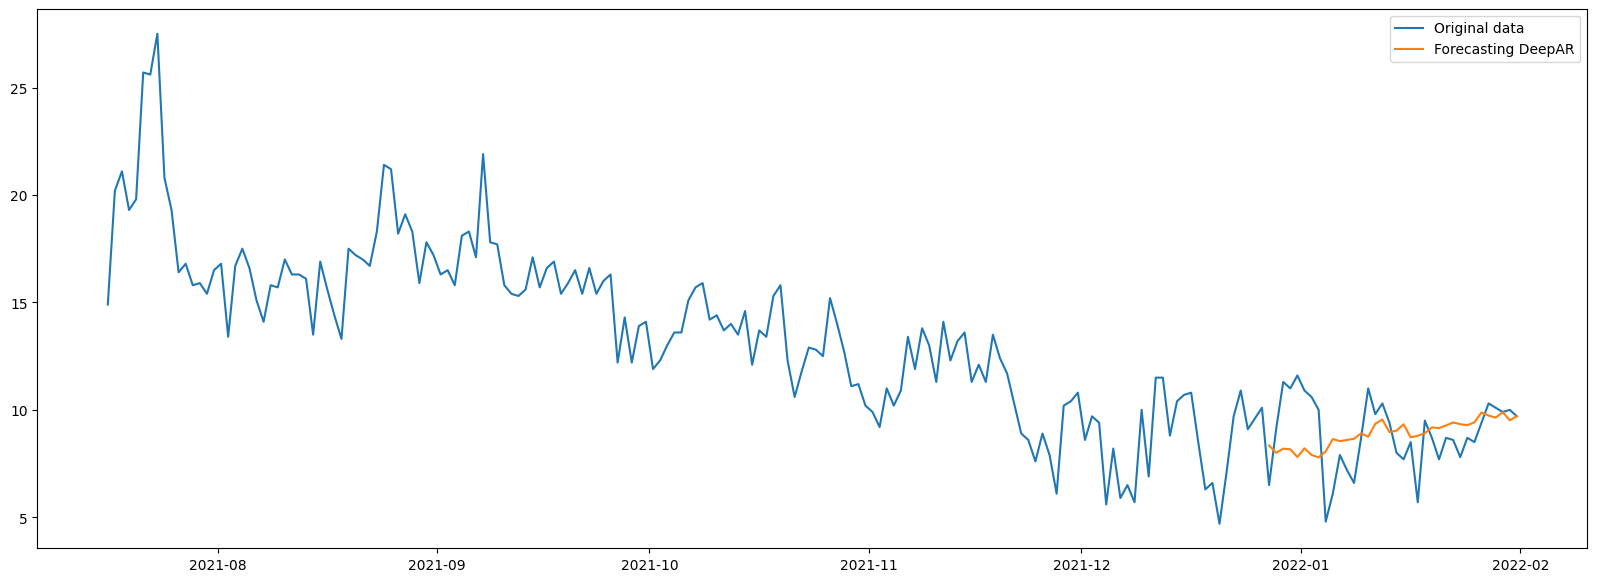

In [21]:
# Plot new predictions
mse = plot_deepar(data, forecast)

In [22]:
# Metrics
print("Temps d'entraînement du modèle : " + str((pd.to_timedelta(computation_time).seconds*1e6 + pd.to_timedelta(computation_time).microseconds)/1e6) + " secondes")
print("Mean Squared Error : " + str(mse[0]))

Temps d'entraînement du modèle : 43.679958 secondes
Mean Squared Error : 2.9852807947391415


## Comparison with AutoRegressive model

In [23]:
computation_time = datetime.now()
res = AutoReg(data[800:964].temp, lags=None, exog=data[800:964][["wetb", "dewpt", "vappr", "rhum"]]).fit()
pred_ar = res.predict(start=data.index[-36], end=data.index[-1], exog_oos=data[-36:][["wetb", "dewpt", "vappr",
                                                                                       "rhum"]])
summary = res.summary()
mse = mean_squared_error(data.temp[-36:], pred_ar)
computation_time = datetime.now() - computation_time
print("Temps d'entraînement du modèle : " + str(computation_time) + " secondes")
print("Mean Squared Error : " + str(mse))

Temps d'entraînement du modèle : 0:00:00.041987 secondes
Mean Squared Error : 0.03241539582024719


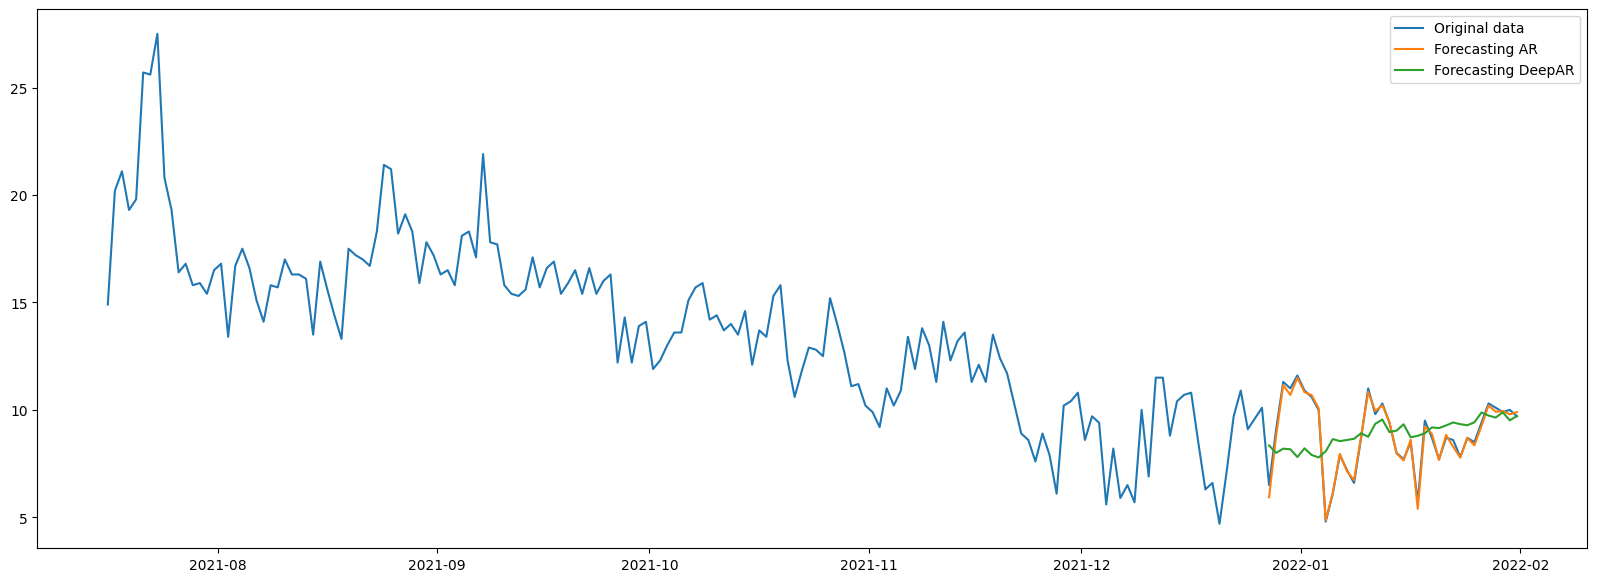

In [24]:
show = final_plot(data, pred_ar, forecast)

# Metrics computations

We try to check the influence of our hyperparameters by analysing 2 metrics : Mean Squared Error and computation time.

Our parameters are different each time, and are contained in those ranges :
- number of LSTM layers : 2 or 3
- number of cells per LSTM layer : 20 or 40
- number of epochs : 10 or 20
- size of batches : 32, 64 or 128
- context_length : 36 (equal to prediction_length), 50, 100 or 200

All the computations are done on the metrics_computation.py file, and are stored in the metrics directory.

A preprocessing has been done to keep only mean values and those values are in the metrics.csv file. The preprocessing is also done on the metrics_computation.py file.


We are comparing the Mean Squared Error and the computation time between those 2 models.


In [25]:
metrics = pd.read_csv("metrics.csv", index_col=[0])
metrics

,batch_size,num_layers,num_cells,epoch,context_length,mean_mse,mean_time
0,32.0,2.0,20.0,10.0,36.0,6.809181,29.977372
1,32.0,2.0,20.0,10.0,50.0,7.627107,35.537869
2,32.0,2.0,20.0,10.0,100.0,7.341357,46.892232
3,32.0,2.0,20.0,10.0,200.0,6.585450,75.291249
4,32.0,2.0,20.0,20.0,36.0,6.623872,58.024135
...,...,...,...,...,...,...,...
75,128.0,2.0,40.0,10.0,200.0,6.678986,237.092601
76,128.0,2.0,40.0,20.0,36.0,8.717045,193.557208
77,128.0,2.0,40.0,20.0,50.0,7.984375,223.487985
78,128.0,2.0,40.0,20.0,100.0,8.204523,306.465070


In [26]:
# We select only the 30 best MSE.
metrics.sort_values("mean_mse")[:30]

,batch_size,num_layers,num_cells,epoch,context_length,mean_mse,mean_time
64,128.0,2.0,20.0,10.0,36.0,6.227539,69.285105
10,32.0,2.0,40.0,10.0,100.0,6.270599,60.384836
41,64.0,2.0,40.0,10.0,50.0,6.276216,64.799676
73,128.0,2.0,40.0,10.0,50.0,6.324475,105.195239
57,64.0,3.0,40.0,10.0,50.0,6.387405,91.994422
9,32.0,2.0,40.0,10.0,50.0,6.400429,40.881841
65,128.0,2.0,20.0,10.0,50.0,6.435859,77.466553
49,64.0,3.0,20.0,10.0,50.0,6.445691,65.173975
16,32.0,3.0,20.0,10.0,36.0,6.578931,38.911723
3,32.0,2.0,20.0,10.0,200.0,6.585450,75.291249


### Number of epochs

In [29]:
metrics.sort_values("mean_mse")[:30].groupby("epoch").mean()[["mean_mse","mean_time"]]

,mean_mse,mean_time
epoch,,
10.0,6.630662,77.535637
20.0,6.801352,95.371994


Best MSE's obtained for 10 epochs. For the first one with 20 epochs, it might be good cause it's not longer than the other ones, but the second one has a too big computation time.

In [40]:
metrics.sort_values("mean_mse")[:30][metrics.sort_values("mean_mse")[:30].epoch==20.0]

,batch_size,num_layers,num_cells,epoch,context_length,mean_mse,mean_time
4,32.0,2.0,20.0,20.0,36.0,6.623872,58.024135
22,32.0,3.0,20.0,20.0,100.0,6.978832,132.719854


### Batch size

In [41]:
metrics.sort_values("mean_mse")[:30].groupby("batch_size").mean()[["mean_mse","mean_time"]]

,mean_mse,mean_time
batch_size,,
32.0,6.641863,63.768772
64.0,6.664008,70.209309
128.0,6.614153,119.585032


A too big batch_size looks to have a big impact on the computation time.

### Number of cells

In [44]:
metrics.sort_values("mean_mse")[:30].groupby("num_cells").mean()[["mean_mse","mean_time"]]

,mean_mse,mean_time
num_cells,,
20.0,6.678653,71.078845
40.0,6.600199,87.462879


 Having a number of cells equal to 20 makes a mean computation time equal to 71 seconds for the 30 best MSE's, while having 40 cells makes the time up to 87 secondes, while the mean MSE is really close (6.67 for 20 against 6.60 for 40).

### Number of layers

In [45]:
metrics.sort_values("mean_mse")[:30].groupby("num_layers").mean()[["mean_mse","mean_time"]]

,mean_mse,mean_time
num_layers,,
2.0,6.616277,81.382803
3.0,6.680687,74.737614


It's the opposite for having 2 layers of LSTM against 3 : MSE equal to 6.61 and 81.4 seconds in average for 2 layers against a MSE equal to 6.68 and 74.47 seconds of computation time in average. It seems that those 2 hypeparameters are not really influent in those 2 metrics for the 30 best MSE.

### Length of the context

In [47]:
metrics.sort_values("mean_mse")[:30].groupby("context_length").mean()[["mean_mse","mean_time"]]

,mean_mse,mean_time
context_length,,
36.0,6.700669,53.417723
50.0,6.481547,69.134247
100.0,6.726928,94.643428
200.0,6.619941,140.899922


Best MSE's are obtaine when the context_length is equal to 50 (6.48 against 6.70-6.73-6.62 for 36-100-200), while the best computation time are obtained while having a context_length equal to 36 (53.42 seconds against 69.13-94.64-140.90 for 50-100-200). We can see that the bigger the context_length is, the longer the algorithm is.

### Trade-off between computation time and mean MSE

We compute the ratio between the mean computation time and the mean MSE.

In [48]:
pd.DataFrame(metrics.sort_values("mean_mse")[:30].mean_time/metrics.sort_values("mean_mse")[:30].mean_mse, columns = ["trade_off"]).sort_values("trade_off")

,trade_off
0,4.402493
8,5.317216
16,5.914597
9,6.387360
17,6.785783
32,6.880779
24,7.757545
40,8.161296
48,8.169484
4,8.759851


The best trade-off between mean computation time and mean MSE are the one with parameters such that :

In [49]:
metrics.sort_values("mean_mse")[:30][(metrics.sort_values("mean_mse")[:30].index == 0) | (metrics.sort_values("mean_mse")[:30].index == 8) | (metrics.sort_values("mean_mse")[:30].index == 16) | (metrics.sort_values("mean_mse")[:30].index == 9) | (metrics.sort_values("mean_mse")[:30].index == 17)]

,batch_size,num_layers,num_cells,epoch,context_length,mean_mse,mean_time
9,32.0,2.0,40.0,10.0,50.0,6.400429,40.881841
16,32.0,3.0,20.0,10.0,36.0,6.578931,38.911723
8,32.0,2.0,40.0,10.0,36.0,6.681992,35.529596
17,32.0,3.0,20.0,10.0,50.0,6.718686,45.591544
0,32.0,2.0,20.0,10.0,36.0,6.809181,29.977372


It seems that the best one if the first one, having the smallest MSE while the fourth best computation time of those models, a bit higher compared to the mean time (40.88 against 38.17).

We will consider the best model as the one with the following hyperparameters :
- 2 LSTM layers with 40 cells each
- trained on 10 epochs with a context_length of 50 and batches of size 32

It's a very similar from the default model, which have :
- 2 LSTM layers with 40 cells each
- trained on 10 epochs with a context_length equal to 36 (in reality equal to prediction_length) and batches of size 32
And this model is also one of the models with the best trade-off between the mean computation time and the mean MSE. It's MSE is a bit bigger (6.68 against 6.40) but he is more than 5 seconds quicker (35.53 against 40.88).

## Streamlit application

We finally designed a Streamlit application, allowing you to forecast the weather of a station using both methods. The app is contained in the stramlit_app application. To run it, you just have to type `python -m streamlit run streamlit_app/app.py` on a terminal in a environment with streamlit installed, or running the following cell.

In [87]:
%%bash
python -m streamlit run streamlit_app/app.py


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://10.32.42.26:8501

  For better performance, install the Watchdog module:

  $ xcode-select --install
  $ pip install watchdog
            


2023-01-12 10:25:20.181 Using CPU
/Users/arthurboivert/venv38/lib/python3.8/site-packages/gluonts/model/deepar/__init__.py:18: FutureWarning: The module gluonts.model.deepar has been moved to gluonts.mx.model.deepar. In GluonTS v0.12 it will be no longer possible to use the old path. Try to use 'from gluonts.mx import DeepAREstimator'.
  warnings.warn(
2023-01-12 10:25:20.709 Uncaught app exception
Traceback (most recent call last):
  File "/Users/arthurboivert/venv38/lib/python3.8/site-packages/streamlit/runtime/scriptrunner/script_runner.py", line 562, in _run_script
    exec(code, module.__dict__)
  File "/Users/arthurboivert/Desktop/projet_hddl_v2/streamlit_app/app.py", line 25, in <module>
    df = data.data_import("../stations/" + stations[station] + "_" + station + ".csv")
  File "/Users/arthurboivert/Desktop/projet_hddl_v2/streamlit_app/dataset_import.py", line 5, in data_import
    df = pd.read_csv(name).dropna()
  File "/Users/arthurboivert/venv38/lib/python3.8/site-packages/

  Stopping...


/Users/arthurboivert/venv38/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/arthurboivert/venv38/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


Error while terminating subprocess (pid=49698): 
